In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeClassifier, LassoCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import skew
import itertools

This time the df contains data on both products merged togheter (simple ctrl+v in excel)

In [2]:
df = pd.read_excel(r"C:\Users\loren\Desktop\merged_file.xlsx")
df.dropna(inplace=True)

# Encode categorical variable
df = pd.get_dummies(df, columns=['Municipality', "Product"])

# Select features and target
features = ['StdDeviation', 'CV', 'HM', 'Skewness']
X = df[features]
y = df['isCollusion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ridge

First we use the classifier with cross validation to determine the most optimal alpha.

The classifier is necessary as the orignal Ridge modle, without classification, will not work when predicting binary variables with continous feature. This was not an issue when standardizing the values.

[GUIDE](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html): This classifier first converts the target values into {-1, 1} and then treats the problem as a regression task (multi-output regression in the multiclass case).


In [3]:
### RIDGE - ALPHA

k_folds = 10 

ridge_model = RidgeClassifier()

accuracies = []

cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge_model.set_params(alpha=alpha)
    fold_accuracies = [] 
    for train_idx, test_idx in cv_stratified.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        ridge_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = ridge_model.predict(X_test_fold)
        
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    mean_accuracy = np.mean(fold_accuracies)
    accuracies.append(mean_accuracy)
    
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")

Alpha=0.001: Mean Accuracy: 0.8942492148374501
Alpha=0.01: Mean Accuracy: 0.894902809608692
Alpha=0.1: Mean Accuracy: 0.8935956200662083
Alpha=1: Mean Accuracy: 0.8896782955606485
Alpha=10: Mean Accuracy: 0.8531321619556913
Alpha=100: Mean Accuracy: 0.5868177574059926


In [55]:
### RIDGE - MODEL

confusion_matrices = {}
feature_names = []
accuracies = []

ridge_model = RidgeClassifier(alpha=0.01)
ridge_model.fit(X_train, y_train)
y_pred_all = ridge_model.predict(X_test)

y_pred_ridge = [1 if pred > 0.5 else 0 for pred in y_pred_all]

all_features_coefficients = np.abs(ridge_model.coef_[:])
Ridge_cm = confusion_matrix(y_test, y_pred_ridge)
confusion_matrices["AllFeatures"] = Ridge_cm

comb_accuracy = accuracy_score(y_test, y_pred_ridge)

print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using all features: 88.02%


In [11]:
print(f"Confusion Matrix:\n {Ridge_cm}")

Confusion Matrix:
 [[187  46]
 [  0 151]]


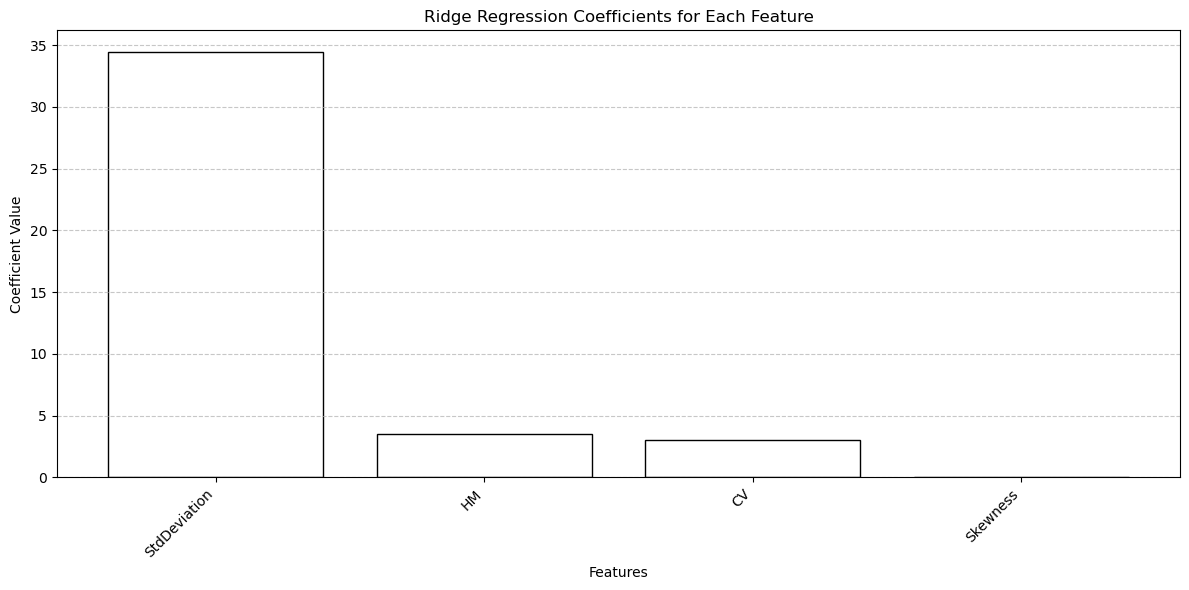

In [31]:
### FEATURE SELECTION

all_features_coefficients = np.abs(ridge_model.coef_)[0]
feature_coefficients = dict(zip(features, all_features_coefficients))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
sorted_coefficients

[('StdDeviation', 34.466894597919364),
 ('HM', 3.482098349907686),
 ('CV', 3.023432964000823),
 ('Skewness', 0.00012391485756809304)]

Interesting to see how even with a very small alpha, skewness is dropped to almost zero (0.000124). Standard Deviation becomes the most important feature, while HM and CV drop, probably beacause of thier collinearity.

## LASSO

Again, we first identify the optimal alpha with cross validation.

In [33]:
k_folds = 10

lasso_model = Lasso()

cv_stratified = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
    
for alpha in alphas:
    lasso_model.alpha = alpha
    fold_accuracies = [] 
    for train_idx, test_idx in cv_stratified.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx] 
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]
        lasso_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = (lasso_model.predict(X_test_fold) > 0.5).astype(int)
        fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)
        fold_accuracies.append(fold_accuracy)
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Alpha={alpha}: Mean Accuracy: {mean_accuracy}")


Alpha=0.001: Mean Accuracy: 0.8909854851031321
Alpha=0.01: Mean Accuracy: 0.8583524318818435
Alpha=0.1: Mean Accuracy: 0.6077030812324928
Alpha=1: Mean Accuracy: 0.6077030812324928
Alpha=10: Mean Accuracy: 0.6077030812324928
Alpha=100: Mean Accuracy: 0.6077030812324928


We run the LASSO model.

In [52]:
lasso_model = Lasso(alpha=0.001) 
lasso_model.fit(X_train, y_train)

y_pred_all = lasso_model.predict(X_test)

y_pred_lasso = [1 if pred > 0.5 else 0 for pred in y_pred_all]

all_features_coefficients = np.abs(lasso_model.coef_)
LASSO_cm = confusion_matrix(y_test, y_pred_lasso)
confusion_matrices["AllFeatures"] = LASSO_cm

comb_accuracy = accuracy_score(y_test, y_pred_lasso)
accuracies.append(comb_accuracy)

feature_names.append("All Features")
print(f'Accuracy using all features: {round(comb_accuracy*100, 2)}%')

Accuracy using all features: 87.76%


In [110]:
print(f"Confusion Matrix:\n {LASSO_cm}")

Confusion Matrix:
 [[186  47]
 [  0 151]]


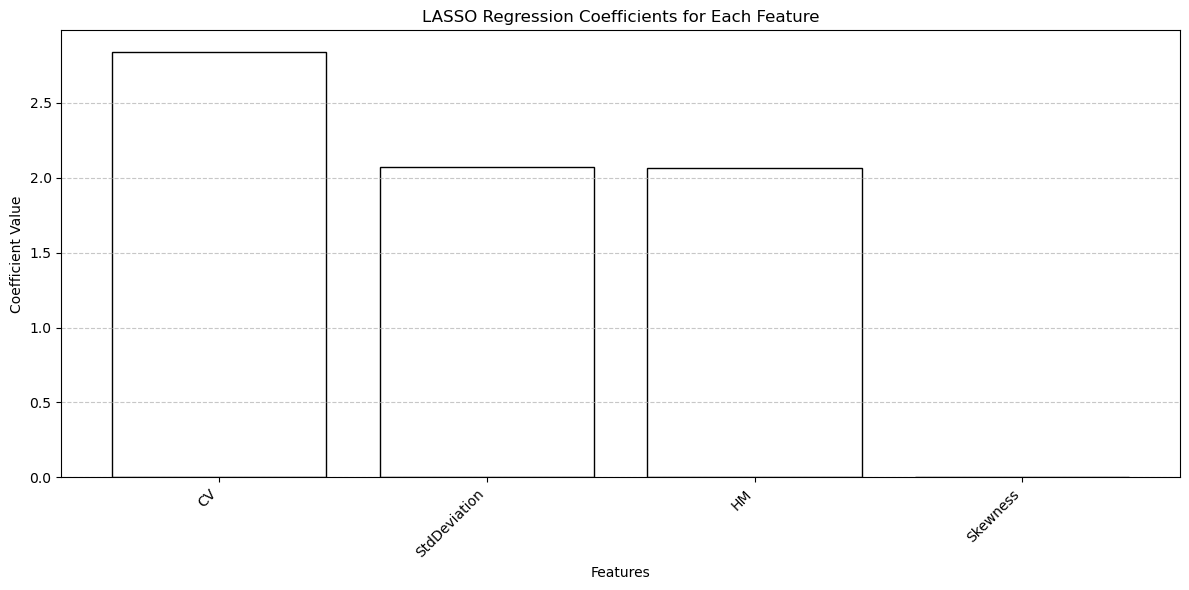

In [35]:
feature_coefficients = dict(zip(features, abs(lasso_model.coef_)))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('LASSO Regression Coefficients for Each Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
feature_coefficients

{'StdDeviation': 2.073744838248734,
 'CV': 2.841162980115324,
 'HM': 2.061286194892632,
 'Skewness': 0.0030760613412616584}

With LASSO we reach a similiar accuracy to Ridge. However, CV is now the most important feature and HM also gains in coefficient size, wrt to other features. Skewness remains close to zero but not equal to zero. Increasing alpha, even to 0.01, would drop all features except HM, but there is a too large drop in accuracy, characterized by false-negatives.

BELOW THE OUTPUT FOR ALPHA = 0.01:

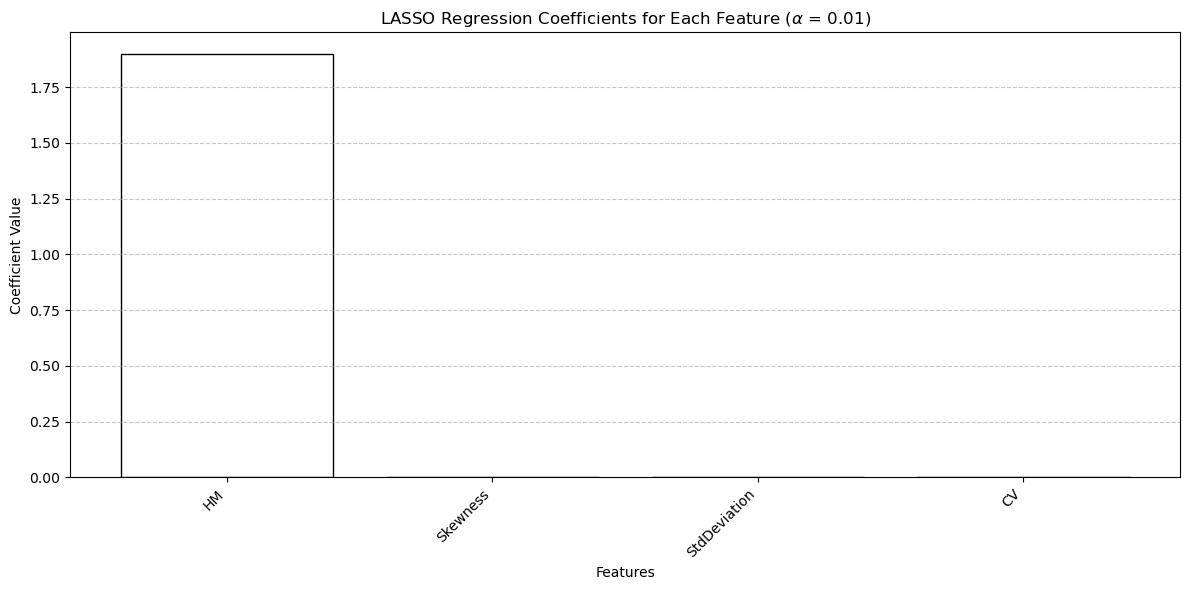

In [37]:
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

y_pred_all = lasso_model.predict(X_test)

y_pred_all_binary = [1 if pred > 0.5 else 0 for pred in y_pred_all]

all_features_coefficients = np.abs(lasso_model.coef_)
LASSO1_cm = confusion_matrix(y_test, y_pred_all_binary)
confusion_matrices["AllFeatures"] = LASSO1_cm

comb_accuracy = accuracy_score(y_test, y_pred_all_binary)
accuracies.append(comb_accuracy)

feature_names.append("All Features")

feature_coefficients = dict(zip(features, abs(lasso_model.coef_)))

sorted_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_coeffs = zip(*sorted_coefficients)

plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_coeffs, edgecolor='black', hatch='', color='white')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title(r'LASSO Regression Coefficients for Each Feature ($\alpha$ = 0.01)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
print(f"Confusion Matrix:\n {LASSO1_cm}\n Features Coefficients:\n {feature_coefficients}")

Confusion Matrix:
 [[187  46]
 [ 18 133]]
 Features Coefficients:
 {'StdDeviation': 0.0, 'CV': 0.0, 'HM': 1.9012298700622847, 'Skewness': 0.0023319960662088733}


## Neural Network

First we define a function that iterates throught different parameters for the network architecture. It runs across different numbers of nodes and learning rates. It then records and prints the most accurate settings. We also need to save the recorded weight that gave the highest accuracy, otherwise the model would give different results every run due to randomization.

In [45]:
# Define function with ranges for hyperparameters
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=[X_train.shape[1]]
    ))
    model.add(layers.Dense(
        units=hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Tuner Function: Iterate the model on different parmeters while looking for most accurate settings
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

## Callback: stop training early if there is no improvement
stop_early = EarlyStopping(monitor='val_loss', patience=5)

## Optimal Parameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early]);
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f""" First Layer Nodes: {best_hps.get('units_1')}\n Second Layer Nodes: {best_hps.get('units_2')}\n Learning Rate: {best_hps.get('learning_rate')}""")

Reloading Tuner from my_dir\intro_to_kt\tuner0.json
 First Layer Nodes: 224
 Second Layer Nodes: 80
 Learning Rate: 0.01


In [46]:
# Define the model with best hyperparameters
best_model = build_model(best_hps)

# Train the model
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Save the best model weights during training (avoids randomization on repetition)
checkpoint_path = "best_model_weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor='val_accuracy', 
                                      verbose=1, 
                                      save_best_only=True,
                                      mode='max')

# Fit the model and save the best weights
best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early, checkpoint_callback]);

Epoch 1/50
39/39 [==============================] - 1s 11ms/step - loss: 0.4765 - accuracy: 0.7780 - val_loss: 0.3040 - val_accuracy: 0.9186
Epoch 2/50
39/39 [==============================] - 0s 5ms/step - loss: 0.2809 - accuracy: 0.8922 - val_loss: 0.2680 - val_accuracy: 0.9316
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 0.2594 - accuracy: 0.9020 - val_loss: 0.2320 - val_accuracy: 0.9283
Epoch 4/50
39/39 [==============================] - 0s 4ms/step - loss: 0.2418 - accuracy: 0.9029 - val_loss: 0.2209 - val_accuracy: 0.9316
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 0.2186 - accuracy: 0.9061 - val_loss: 0.2067 - val_accuracy: 0.9283
Epoch 6/50
39/39 [==============================] - 0s 5ms/step - loss: 0.1948 - accuracy: 0.9208 - val_loss: 0.2032 - val_accuracy: 0.9251
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 0.1661 - accuracy: 0.9363 - val_loss: 0.1832 - val_accuracy: 0.9446
Epoch 8/50
39/39 [=

We then run the tuned model with the obtained parameters.

In [47]:
### NEURALNETWORK MODEL
best_model.load_weights(checkpoint_path)

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {round(test_accuracy*100, 2)}%')

12/12 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9844
Test Accuracy: 98.44%


In [56]:
# CONFUSION MATRIX
y_pred = best_model.predict(X_test)
y_pred_nn = (y_pred > 0.5).astype(int)

NN_cm = confusion_matrix(y_test, y_pred_nn)

print("Confusion Matrix:")
print(NN_cm)

12/12 [==============================] - 0s 2ms/step
Confusion Matrix:
[[227   6]
 [  0 151]]


## Investigate False Positives

We further analyze the cases of false positives obtained with the three models. First we extract from the confision matrices the incorrectly predicted data points, then we match them with the original df to have a comprehensive list of all the information for those points.

In [70]:
# For some reasons the prediction for the NN are in a list of arrays, I store them as a single array
nn_pred_array = list(itertools.chain(*y_pred_nn))

# Function to disect confusion matrices
def get_fp_fn(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fp_indices = np.where((y_true == 0) & (np.array(y_pred) == 1))[0]
    fn_indices = np.where((y_true == 1) & (np.array(y_pred) == 0))[0]
    return fp_indices, fn_indices

# Get false positives and false negatives for each model
fp_lasso, fn_lasso = get_fp_fn(y_test, y_pred_lasso)
fp_ridge, fn_ridge = get_fp_fn(y_test, y_pred_ridge)
fp_nn, fn_nn = get_fp_fn(y_test, single_array)


# Retrieve the instances from the original df
df_fp_lasso = df.iloc[fp_lasso]
df_fn_lasso = df.iloc[fn_lasso]

df_fp_ridge = df.iloc[fp_ridge]
df_fn_ridge = df.iloc[fn_ridge]

df_fp_nn = df.iloc[fp_nn]
df_fn_nn = df.iloc[fn_nn]



LASSO False Positives:
          Date  PriceMean  StdDeviation        CV  NatMean        HM  \
0   2015-01-05   0.579048      0.012722  0.021970  0.55119 -0.027858   
16  2015-04-27   0.586113      0.010382  0.017709  0.58575 -0.000363   
19  2015-05-18   0.597627      0.016342  0.027338  0.59813  0.000503   
20  2015-05-25   0.596261      0.015325  0.025702  0.59749  0.001229   
30  2015-08-03   0.537713      0.037867  0.070434  0.54426  0.006547   
43  2015-11-02   0.429321      0.004826  0.011241  0.47957  0.050249   
50  2015-12-21   0.392319      0.036311  0.092782  0.43041  0.038091   
52  2016-01-04   0.377487      0.037877  0.100349  0.41217  0.034683   
60  2016-02-29   0.364606      0.046983  0.128885  0.36573  0.001124   
67  2016-04-18   0.384122      0.035589  0.092687  0.39363  0.009508   
88  2016-09-12   0.427155      0.013173  0.030797  0.44744  0.020285   
101 2016-12-12   0.463865      0.016511  0.035532  0.48920  0.025335   
104 2017-01-02   0.507659      0.008782  

In [71]:
print("LASSO False Positives:")
print(df_fp_lasso)

LASSO False Positives:
          Date  PriceMean  StdDeviation        CV  NatMean        HM  \
0   2015-01-05   0.579048      0.012722  0.021970  0.55119 -0.027858   
16  2015-04-27   0.586113      0.010382  0.017709  0.58575 -0.000363   
19  2015-05-18   0.597627      0.016342  0.027338  0.59813  0.000503   
20  2015-05-25   0.596261      0.015325  0.025702  0.59749  0.001229   
30  2015-08-03   0.537713      0.037867  0.070434  0.54426  0.006547   
43  2015-11-02   0.429321      0.004826  0.011241  0.47957  0.050249   
50  2015-12-21   0.392319      0.036311  0.092782  0.43041  0.038091   
52  2016-01-04   0.377487      0.037877  0.100349  0.41217  0.034683   
60  2016-02-29   0.364606      0.046983  0.128885  0.36573  0.001124   
67  2016-04-18   0.384122      0.035589  0.092687  0.39363  0.009508   
88  2016-09-12   0.427155      0.013173  0.030797  0.44744  0.020285   
101 2016-12-12   0.463865      0.016511  0.035532  0.48920  0.025335   
104 2017-01-02   0.507659      0.008782  

In [72]:
print("\nRidge False Positives:")
print(df_fp_ridge)


Ridge False Positives:
          Date  PriceMean  StdDeviation        CV  NatMean        HM  \
0   2015-01-05   0.579048      0.012722  0.021970  0.55119 -0.027858   
16  2015-04-27   0.586113      0.010382  0.017709  0.58575 -0.000363   
19  2015-05-18   0.597627      0.016342  0.027338  0.59813  0.000503   
20  2015-05-25   0.596261      0.015325  0.025702  0.59749  0.001229   
30  2015-08-03   0.537713      0.037867  0.070434  0.54426  0.006547   
43  2015-11-02   0.429321      0.004826  0.011241  0.47957  0.050249   
50  2015-12-21   0.392319      0.036311  0.092782  0.43041  0.038091   
52  2016-01-04   0.377487      0.037877  0.100349  0.41217  0.034683   
60  2016-02-29   0.364606      0.046983  0.128885  0.36573  0.001124   
67  2016-04-18   0.384122      0.035589  0.092687  0.39363  0.009508   
88  2016-09-12   0.427155      0.013173  0.030797  0.44744  0.020285   
101 2016-12-12   0.463865      0.016511  0.035532  0.48920  0.025335   
104 2017-01-02   0.507659      0.008782 

In [75]:
print("\nNeural Network False Positives:")
print(df_fp_nn)


Neural Network False Positives:
          Date  PriceMean  StdDeviation        CV  NatMean        HM  \
0   2015-01-05   0.579048      0.012722  0.021970  0.55119 -0.027858   
52  2016-01-04   0.377487      0.037877  0.100349  0.41217  0.034683   
108 2017-01-30   0.529321      0.008197  0.015485  0.52642 -0.002901   
142 2017-09-25   0.491851      0.011710  0.023799  0.50821  0.016359   
198 2018-10-22   0.628306      0.041907  0.066694  0.66714  0.038834   
269 2020-02-17   0.566207      0.004098  0.007238  0.56404 -0.002167   

     Skewness  isCollusion  Municipality_LV  Municipality_SO  Product_Diesel  \
0   -4.555323            0                0                1               1   
52   0.000000            0                0                1               1   
108  0.000000            0                0                1               1   
142  6.983329            0                0                1               1   
198  7.937254            0                0                1  

We immidiately see how in all models, the false positives are found in the municipality of Sondrio (competitive) for the diesel product. The cases for Ridge and LASSO all match, similiary the six data points in the NN model are found in the other two. One could think that maybe there was an actual cartel that was not actually detected, but the quasi-randomness in the dates of those prediction suggests otherwise. Hence, we say that it is simply a wrong classification of the four features.

Because of this analysis, below is the code to compute the differences between the values of each feature across the wrongly and correctly predicted positives. Averaged out per model. Because the values are continious they might differ on scales, as such to allow a better comparison we will standardize them.

In [82]:
## Function to extract only false and true positives
def get_fp_tp(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fp_indices = np.where((y_true == 0) & (np.array(y_pred) == 1))[0]
    tp_indices = np.where((y_true == 1) & (np.array(y_pred) == 1))[0]
    return fp_indices, tp_indices


# Extract values
fp_lasso, tp_lasso = get_fp_tp(y_test, y_pred_lasso)
fp_ridge, tp_ridge = get_fp_tp(y_test, y_pred_ridge)
fp_nn, tp_nn = get_fp_tp(y_test, nn_pred_array)

# Retrieve the instances from the original df
df_fp_lasso = df.iloc[fp_lasso]
df_tp_lasso = df.iloc[tp_lasso]

df_fp_ridge = df.iloc[fp_ridge]
df_tp_ridge = df.iloc[tp_ridge]

df_fp_nn = df.iloc[fp_nn]
df_tp_nn = df.iloc[tp_nn]

# Standardize the values
scaler = StandardScaler()

scaled_fp_lasso = scaler.fit_transform(df_fp_lasso[features])
scaled_tp_lasso = scaler.transform(df_tp_lasso[features])

scaled_fp_ridge = scaler.fit_transform(df_fp_ridge[features])
scaled_tp_ridge = scaler.transform(df_tp_ridge[features])

scaled_fp_nn = scaler.fit_transform(df_fp_nn[features])
scaled_tp_nn = scaler.transform(df_tp_nn[features])

# Calculate mean
mean_scaled_fp_lasso = pd.DataFrame(scaled_fp_lasso, columns=features).mean()
mean_scaled_tp_lasso = pd.DataFrame(scaled_tp_lasso, columns=features).mean()

mean_scaled_fp_ridge = pd.DataFrame(scaled_fp_ridge, columns=features).mean()
mean_scaled_tp_ridge = pd.DataFrame(scaled_tp_ridge, columns=features).mean()

mean_scaled_fp_nn = pd.DataFrame(scaled_fp_nn, columns=features).mean()
mean_scaled_tp_nn = pd.DataFrame(scaled_tp_nn, columns=features).mean()

# Store Differences
std_diff_mean_df = pd.DataFrame({
    'LASSO': mean_scaled_fp_lasso - mean_scaled_tp_lasso,
    'Ridge': mean_scaled_fp_ridge - mean_scaled_tp_ridge,
    'Neural Network': mean_scaled_fp_nn - mean_scaled_tp_nn
})

print(std_diff_mean_df)

                 LASSO     Ridge  Neural Network
StdDeviation -0.243739 -0.225083       -0.004073
CV           -0.178014 -0.162557        0.049708
HM            0.468960  0.469331        0.379311
Skewness      0.462497  0.468649        0.392646


Even with this analysis its hard to find a clear pattern in the mistaken predictions. By using the most accurate model (NN) as benchmark, we can infer how the main factors could be too low stdDeviation hence larger negatives in LASSO and Ridge. Similiarly for CV but in a smaller scale. 

Overall, I dont think we can make a specific conclusion on the reason for these false positive, but rather they are attributable to the "randomness" of the recorded prices.